In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA

from sklearn.metrics import silhouette_score

from sklearn.preprocessing import PowerTransformer, StandardScaler, MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, median_absolute_error, explained_variance_score



from sklearn.model_selection import train_test_split

from statsmodels.stats.outliers_influence import variance_inflation_factor


pd.options.display.max_columns = None
pd.options.display.float_format = "{:,.4f}".format



In [2]:
def plot_scatter_chart(df_plot, target_col):
    columns_to_plot = list(df_plot.columns)
    columns_to_plot.remove(target_col)
    n_axs = len(columns_to_plot)
    n_cols = 4
    n_rows = n_axs//n_cols
    if n_axs%n_cols>0:
        n_rows = n_rows + 1 
    fig  =  plt.figure(figsize=(n_cols*4, n_rows*4), linewidth=3, edgecolor='grey')
    for i, col in enumerate(columns_to_plot):
        ax = fig.add_subplot(n_rows, n_cols, i+1)
        sns.regplot(x=col, y=target_col, data=df_plot, ax=ax, scatter_kws={'alpha':0.8}, line_kws={'color':'orange'})
    plt.show()  

    
    
def get_regression_features(df_plot, target_col):
    columns_to_plot = list(df_plot.columns)
    columns_to_plot.remove(target_col)
    results = {}
    for col in columns_to_plot:
        m, b = np.polyfit(df_plot[col], df_plot[target_col], 1)
        results[col] = m
    return results
    
def get_correlation_of_continuous_features(df_plot, target_col):
    columns_to_plot = list(df_plot.columns)
    columns_to_plot.remove(target_col)
    results = {}
    for col in columns_to_plot:
        results[col] = np.corrcoef(x = df_plot[col], y=df_plot[target_col])[0, 1]
    return results    

def get_correlation_of_categorical_features(df_plot, target_col):
    import statsmodels.api as sm
    from statsmodels.formula.api import ols
    columns_to_plot = list(df_plot.columns)
    columns_to_plot.remove(target_col)
    results = {}
    for col in columns_to_plot:
        model = ols(target_col + '~' + col, data = df_plot).fit()
        result_anova = sm.stats.anova_lm(model)
        results[col] = result_anova.loc[col, 'PR(>F)']
    return results
    
def get_correlation_of_categorical_features_1(df_plot, target_col):
    from scipy import stats 
    columns_to_plot = list(df_plot.columns)
    columns_to_plot.remove(target_col)
    results = {}
    for col in columns_to_plot:
        category_group_list=df_plot.groupby(col)[target_col].apply(list)
        results[col] = stats.f_oneway(*category_group_list)[1]
    return results    
   

def get_chi_correlation_of_categorical_features(df_plot):
    from scipy.stats import chi2_contingency
    df_result = pd.DataFrame()
    col_list = sorted(list(df_plot.columns))
    for col in sorted(list(df_plot.columns)):
#        col_list.remove(col)
        for col_i in col_list:
            if col!=col_i:
                data=df_plot[[col, col_i]].groupby([col, col_i]).size().unstack()
                df_result.loc[col, col_i] = chi2_contingency(data)[1]
            else:
                df_result.loc[col, col_i] = 0
    return df_result

        
    

In [3]:
#df = pd.read_csv('Data_Set.csv', low_memory=False, index_col='custid')


df = pd.read_csv('Data_Set.csv', low_memory=False)

#df.index = df['custid']

#df_cluster = pd.read_csv('clusters.csv')
#df = pd.concat([df, df_cluster], axis=1)

In [4]:
log_columns = list(filter(lambda x:x.startswith('ln'), df.columns))
df.drop(columns=log_columns, inplace=True)

df.loc[:, ['total_spent']] = df['cardspent'] + df['card2spent']
df.loc[:, ['debtinc']] =  df['debtinc']*df['income']/100.0
df.drop(['cardspent', 'card2spent'], axis=1, inplace=True)

df.drop(columns=['custid', 'birthmonth'], inplace=True)

df.replace('#NULL!', np.nan, inplace=True)
df.fillna(df.median(), inplace=True)

df['carvalue'].replace(-np.inf, 0.001, inplace=True)
df['carvalue'].replace(-1, 0.001, inplace=True)


In [5]:
df.isna().sum().sum()

0

In [6]:

#df.loc[:, ['cardmon_total']] = df[['cardmon', 'wiremon', 'longmon', 'equipmon', 'tollmon']].sum(axis=1) 
#df.loc[:, ['cardten_total']] = df[['cardten', 'wireten', 'longten', 'equipten', 'tollten']].sum(axis=1)#/(df['tenure']*1.0)
#df.loc[:, ['have_car']] = df[['carbought', 'carbuy']].sum(axis=1).apply(lambda x: 1 if x > 0 else 0)

features_own_tv = list(filter(lambda x: x.lower().find('own')==0, df.columns))
#df.loc[:, 'own_tv_set_1'] = df[features_own_tv[:4]].sum(axis=1).apply(lambda x: 1 if x > 0 else 0)
#df.loc[:, 'own_tv_set_2'] = df[features_own_tv[4:]].sum(axis=1).apply(lambda x: 1 if x > 0 else 0)

#df.loc[:, ['debt_total']] = df[['creddebt', 'othdebt']].sum(axis=1)


features_pets = [x for x in df.columns if x.lower().startswith('pets') and x.lower()!='pets']
df.drop(features_pets, axis=1, inplace=True)


#df.drop(['cardten', 'wireten', 'longten', 'equipten', 'tollten'], axis=1, inplace=True)
#df.drop(['cardmon', 'wiremon', 'longmon', 'equipmon', 'tollmon'], axis=1, inplace=True)
df.drop(['callcard', 'wireless', 'equip', 'tollfree'], axis=1, inplace=True)

#df.drop(columns=['region', 'townsize'], inplace=True)
df.drop(columns=[ 'gender'], inplace=True)
df.drop(columns=['polview', 'polparty', 'polcontrib', 'vote',
                 'cardbenefit', 'card2benefit', 'churn', 'multline', 'voice', 'news'
                , 'response_01', 'response_02', 'response_03'], inplace=True)

df.drop(columns=['cardfee', 'card2fee'], inplace=True)
df.drop(columns=['cardtype', 'card2type'], inplace=True)

df.drop(columns=['pager'], inplace=True)
df.drop(columns=['active', 'bfast', 'internet', 'callid', 'callwait', 'forward', 'confer', 'ebill'], inplace=True)

df.drop(columns=['tenure'], inplace=True)
df.drop(['homeown', 'hometype'], axis=1, inplace=True)
df.drop(['spousedcat', 'edcat'], axis=1, inplace=True)
df.drop(['spoused'], axis=1, inplace=True)
df.drop(['addresscat', 'address'], axis=1, inplace=True)
df.drop(['inccat'], axis=1, inplace=True)
#df.drop(columns=['union', 'retire', 'cardfee', 'card2fee', 'carown'], inplace=True)

commute_to_drop = [x for x in df.columns if 'commute' in x.lower() and x.lower() not in ['commutecat']]
df.drop(columns=commute_to_drop, inplace=True)

df.drop(columns=['carbought', 'carbuy'], inplace=True)

df.drop(['default', 'marital'], axis=1, inplace=True)
#df.drop(features_own_tv, axis=1, inplace=True)


#df.drop(columns=['othdebt'], inplace=True)
#df.drop(columns=['creddebt'], inplace=True)

#df.drop(['carvalue'], axis=1, inplace=True)
#df.drop(['age'], axis=1, inplace=True)
df.drop(['employ'], axis=1, inplace=True)

df.drop(columns=['agecat', 'empcat', 'jobsat'], inplace=True)

df.drop(columns=['carcatvalue', 'cardtenurecat', 'card2tenurecat'], inplace=True)

df.drop(['cardtenure', 'card2tenure'], axis=1, inplace=True)

df.drop(['hourstv'], axis=1, inplace=True)





In [7]:
X = df.drop(columns=['total_spent']).copy()
y = df['total_spent'].copy()
X.replace('#NULL!', np.nan, inplace=True) 
X.fillna(X.mean(), inplace=True)
X.fillna(0, inplace=True)
X = X.convert_dtypes()
cols = X.select_dtypes(float).columns
X[cols] = X[cols].astype(np.float64)
cols = X.select_dtypes(int).columns
X[cols] = X[cols].astype(np.int64)
cols = X.select_dtypes('object').columns
X[cols] = X[cols].astype(np.float64)


In [8]:
act_sum = X.select_dtypes(np.number).sum()
int_sum = X.select_dtypes(np.number).astype(np.int64).sum()

int_columns = X.select_dtypes(np.number).columns[act_sum/int_sum==1]
float_columns = X.select_dtypes(np.number).columns[act_sum/int_sum!=1]
X.loc[:, int_columns] = X[int_columns].astype(np.int64)
X.loc[:, float_columns] = X[float_columns].astype(np.float64)

cat_columns = [col for col in X.columns if X[col].unique().size <= 60]
cont_columns = [col for col in X.select_dtypes(include=[np.number]).columns if col not in cat_columns]

X.loc[:, cat_columns] = X[cat_columns].astype(np.int64).astype('category')

In [9]:
pt = PowerTransformer()
transformer_y = PowerTransformer()
sc = StandardScaler()
#X.loc[:, cont_columns] = pt.fit_transform(sc.fit_transform(X[cont_columns]))
#y = pd.Series(pt.fit_transform(sc.fit_transform(y.values.reshape(-1, 1))).reshape(-1), name='total_spent')

X.loc[:, cont_columns] = pt.fit_transform(X[cont_columns])
y = pd.Series(transformer_y.fit_transform(y.values.reshape(-1, 1)).reshape(-1), name='total_spent')

#X.loc[:, cont_columns] = np.log1p(X[cont_columns])
#y = np.log1p(y)

In [10]:
cont_columns

['age',
 'income',
 'debtinc',
 'creddebt',
 'othdebt',
 'carvalue',
 'longmon',
 'longten',
 'tollmon',
 'tollten',
 'equipmon',
 'equipten',
 'cardmon',
 'cardten',
 'wiremon',
 'wireten']

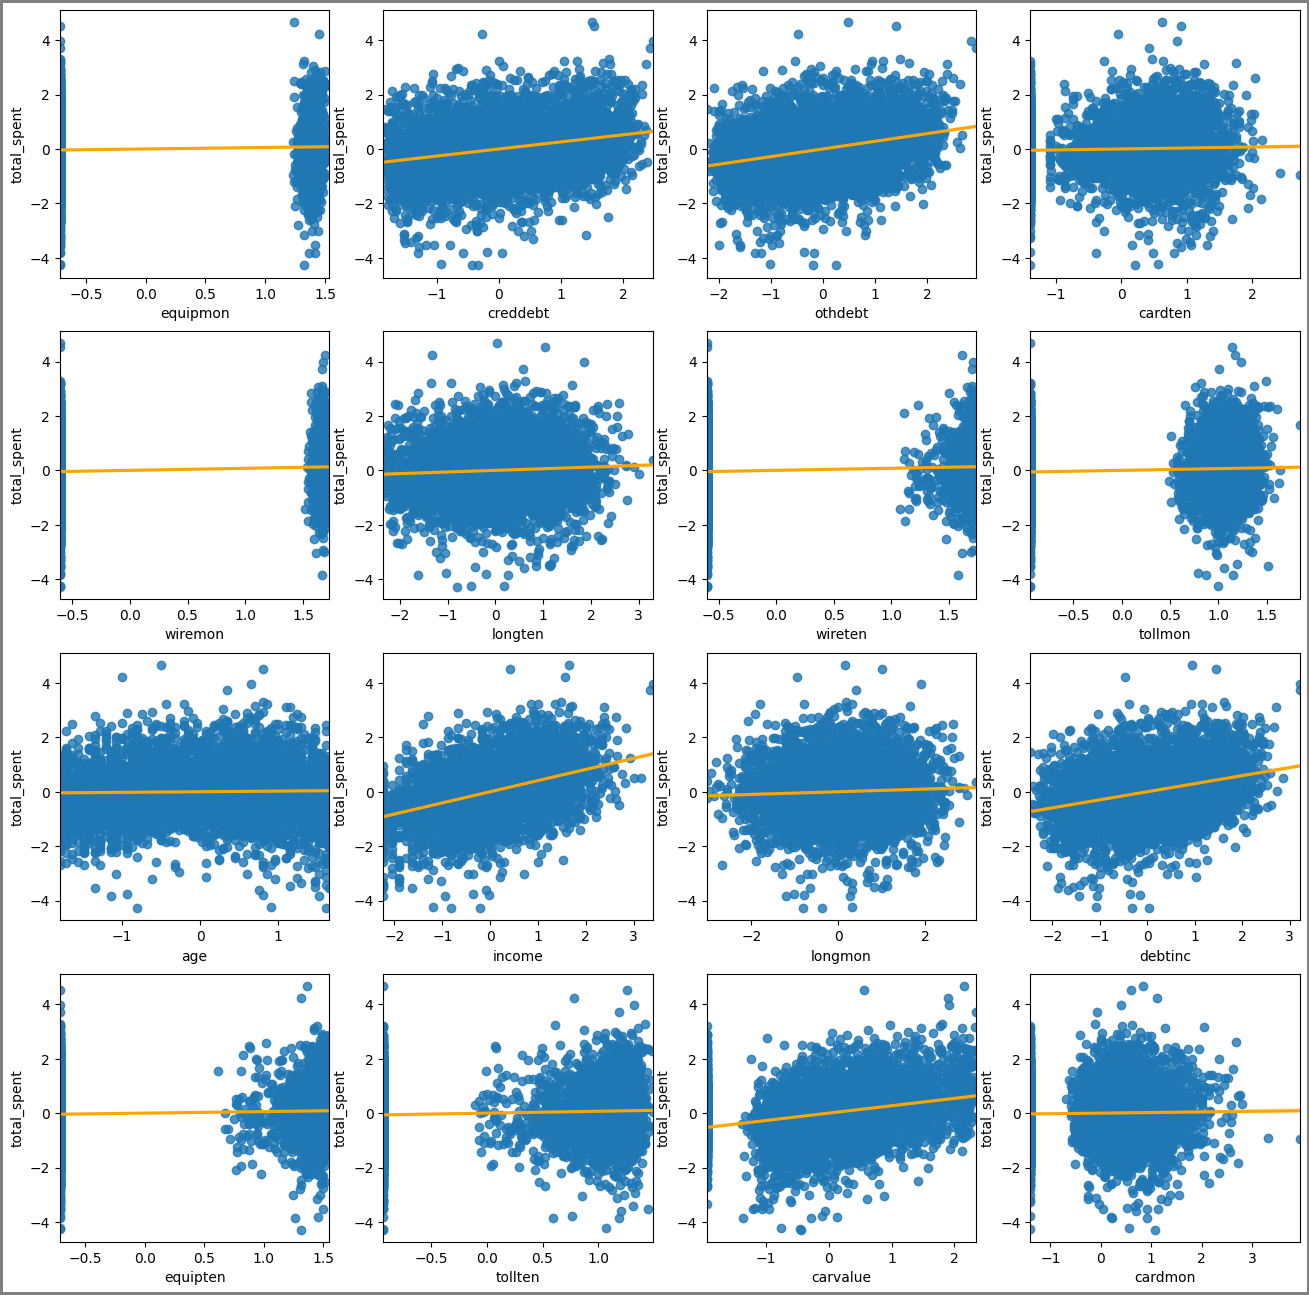

In [11]:
df_plot = pd.concat([X, y], axis=1)
target_col = 'total_spent'
df_plot_local=df_plot[cont_columns + [target_col]]
cols_to_plot = list(df_plot_local.columns)
cols_to_plot = list(set(cols_to_plot))
plot_scatter_chart(df_plot_local[cols_to_plot]+0.001, target_col)

In [12]:
cont_columns_selected  = [
 'income',
 'debtinc',
 'creddebt',
 'othdebt',
 'carvalue',
 'longmon',
]

In [13]:
results = get_regression_features(df_plot[cont_columns + [target_col]], target_col)
dict_cont_columns = {x:y for x,y in results.items() if np.abs(y)>=0.05}
cont_columns_selected = list(dict_cont_columns.keys())
cont_columns_selected

['income',
 'debtinc',
 'creddebt',
 'othdebt',
 'carvalue',
 'longten',
 'tollmon',
 'tollten',
 'equipmon',
 'equipten',
 'wiremon',
 'wireten']

In [14]:
#cont_columns_selected - ['age', 'equipmon', 'cardmon', 'tenure', ]

In [15]:
set(cont_columns) - set(cont_columns_selected)

{'age', 'cardmon', 'cardten', 'longmon'}

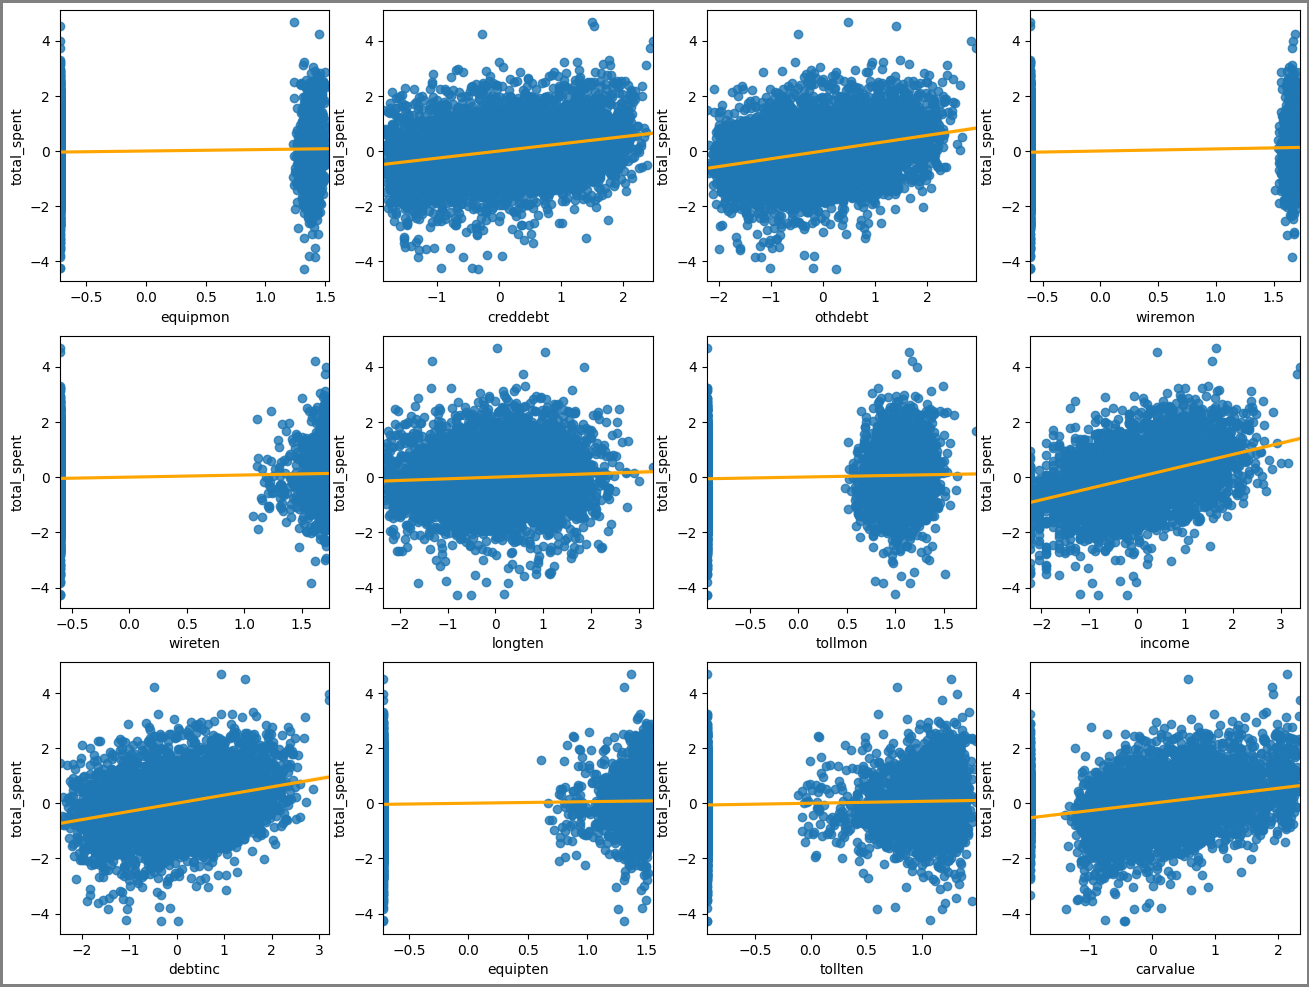

In [16]:
df_plot = pd.concat([X, y], axis=1)
target_col = 'total_spent'
df_plot_local=df_plot[cont_columns_selected + [target_col]]
cols_to_plot = list(df_plot_local.columns)
cols_to_plot = list(set(cols_to_plot))
plot_scatter_chart(df_plot_local[cols_to_plot], target_col)

In [17]:
if 'birthmonth' in cat_columns:
    cat_columns.remove('birthmonth')
results = get_correlation_of_categorical_features(df_plot[cat_columns + [target_col]], target_col)
#dict_cat_columns_eligible = {x:y for x,y in results.items() if np.abs(y)<=200}
dict_cat_columns_eligible = {x:y for x,y in results.items() if np.abs(y)<= 0.05}
cat_columns_selected = list(dict_cat_columns_eligible.keys())
#cat_columns_selected=['card', 'ed', 'jobcat', 'reason']

In [18]:
pd.Series(results).sort_values(ascending=False)

townsize     0.9334
reside       0.8287
commutecat   0.4072
cars         0.3120
cartype      0.1756
union        0.1567
pets         0.1470
region       0.0758
owngame      0.0050
ownipod      0.0038
ownpc        0.0013
ownfax       0.0000
ownpda       0.0000
jobcat       0.0000
ed           0.0000
owntv        0.0000
owncd        0.0000
ownvcr       0.0000
carown       0.0000
reason       0.0000
owndvd       0.0000
card2        0.0000
retire       0.0000
card         0.0000
dtype: float64

In [19]:
target_col = 'total_spent'

df_plot_local=df_plot[list(dict_cat_columns_eligible.keys())]
results = get_chi_correlation_of_categorical_features(df_plot_local)



In [20]:
results.replace('NaN', 0)

,card,card2,carown,ed,jobcat,owncd,owndvd,ownfax,owngame,ownipod,ownpc,ownpda,owntv,ownvcr,reason,retire
card,0.0000,0.0000,0.0000,0.0000,0.6369,0.0498,0.0004,0.0000,0.0000,0.0000,0.0000,0.0000,0.1741,0.0208,0.0000,0.0001
card2,0.0000,0.0000,0.0454,0.0000,0.6392,0.0001,0.0000,0.0059,0.0002,0.0047,0.0000,0.0001,0.0007,0.0001,0.2158,0.0029
carown,0.0000,0.0454,0.0000,0.0022,0.0019,0.0000,0.0000,0.0007,0.0000,0.0000,0.0713,0.0000,0.0000,0.0000,0.1789,0.0000
ed,0.0000,0.0000,0.0022,0.0000,0.0302,0.0017,0.0001,0.0000,0.0000,0.0000,0.0000,0.0000,0.4877,0.0000,0.1141,0.0000
jobcat,0.6369,0.6392,0.0019,0.0302,0.0000,0.0001,0.0001,0.3796,0.0014,0.3956,0.0138,0.0067,0.0033,0.0000,0.3457,0.0000
owncd,0.0498,0.0001,0.0000,0.0017,0.0001,0.0000,0.0000,0.0005,0.3069,0.2822,0.6292,0.0030,0.0000,0.0000,0.8470,0.0000
owndvd,0.0004,0.0000,0.0000,0.0001,0.0001,0.0000,0.0000,0.0095,0.3853,0.9610,0.5399,0.0015,0.0000,0.0000,0.3312,0.0000
ownfax,0.0000,0.0059,0.0007,0.0000,0.3796,0.0005,0.0095,0.0000,0.0000,0.0000,0.0000,0.0000,0.1798,0.0171,0.7604,0.0000
owngame,0.0000,0.0002,0.0000,0.0000,0.0014,0.3069,0.3853,0.0000,0.0000,0.0000,0.0000,0.0000,0.0523,0.2267,0.9542,0.0000
ownipod,0.0000,0.0047,0.0000,0.0000,0.3956,0.2822,0.9610,0.0000,0.0000,0.0000,0.0000,0.0000,0.1723,0.2326,0.8273,0.0000


In [21]:
set(cat_columns) - set(cat_columns_selected)

{'cars',
 'cartype',
 'commutecat',
 'pets',
 'region',
 'reside',
 'townsize',
 'union'}

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=42)
X_train_temp = X_train.copy()
X_test_temp = X_test.copy()

In [23]:
#X_train = X_train[cont_columns_selected + cat_columns_selected]
#X_test = X_test[cont_columns_selected + cat_columns_selected]

ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')
ohe.fit(X_train[cat_columns_selected])
col_names = ohe.get_feature_names(cat_columns_selected)

df_ohe = pd.DataFrame(ohe.transform(X_train[cat_columns_selected]), columns=col_names, index=X_train.index)
X_train.drop(columns=cat_columns_selected, inplace=True)
X_train = pd.concat([X_train, df_ohe], axis=1)
                                            
df_ohe = pd.DataFrame(ohe.transform(X_test[cat_columns_selected]), columns=col_names, index=X_test.index)
X_test.drop(columns=cat_columns_selected, inplace=True)
X_test = pd.concat([X_test, df_ohe], axis=1)

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [24]:
X_train.shape, X_test.shape

((4750, 86), (250, 86))

In [25]:
X_train

,region,townsize,age,union,income,debtinc,creddebt,othdebt,reside,pets,cars,cartype,carvalue,commutecat,longmon,longten,tollmon,tollten,equipmon,equipten,cardmon,cardten,wiremon,wireten,ed_6,ed_7,ed_8,ed_9,ed_10,ed_11,ed_12,ed_13,ed_14,ed_15,ed_16,ed_17,ed_18,ed_19,ed_20,ed_21,ed_22,ed_23,jobcat_1,jobcat_2,jobcat_3,jobcat_4,jobcat_5,jobcat_6,retire_0,retire_1,carown_-1,carown_0,carown_1,reason_1,reason_2,reason_3,reason_4,reason_9,card_1,card_2,card_3,card_4,card_5,card2_1,card2_2,card2_3,card2_4,card2_5,owntv_0,owntv_1,ownvcr_0,ownvcr_1,owndvd_0,owndvd_1,owncd_0,owncd_1,ownpda_0,ownpda_1,ownpc_0,ownpc_1,ownipod_0,ownipod_1,owngame_0,owngame_1,ownfax_0,ownfax_1
4701,5,5,-1.8027,0,-1.1157,-0.2141,-0.4803,-0.0261,4,8,2,0,-0.4506,3,-0.4701,-1.0135,-0.9444,-0.9339,-0.7187,-0.7162,-1.4003,-1.3992,-0.6062,-0.6055,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,1.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,1.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,0.0000,1.0000,0.0000,1.0000,1.0000,0.0000
4118,4,3,-0.0370,0,0.7764,0.6428,-0.0073,0.8999,1,5,2,0,0.5748,1,0.6199,0.7176,1.2402,1.2815,-0.7187,-0.7162,1.0867,1.1240,-0.6062,-0.6055,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000
1652,5,1,-0.6868,1,-0.3071,-0.2945,0.2303,-0.5371,5,0,2,0,-0.2194,1,0.5083,0.5605,-0.9444,-0.9339,1.3968,1.4803,1.0499,1.0617,1.6355,1.6933,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000
1483,5,5,-1.5713,0,-1.2995,-0.5435,0.0546,-0.8377,1,0,4,0,-0.3548,1,-0.0464,-0.6039,-0.9444,-0.9339,-0.7187,-0.7162,-1.4003,-1.3992,-0.6062,-0.6055,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,1.0000,0.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,1.0000,0.0000
2275,3,4,1.3850,0,0.4237,-0.6368,-0.5275,-0.5771,2,3,4,0,0.5143,1,0.4242,0.5837,1.3046,1.3293,1.4355,1.4977,0.4124,0.7654,1.6370,1.6975,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,1.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,1.0000,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4426,4,4,-0.8775,0,-0.0586,-1.7402,-1.6263,-1.4999,1,0,1,1,0.1149,4,0.6560,0.8284,0.9631,1.1659,1.42

In [26]:
#y_train = transformer_y.fit_transform(y_train.values.reshape(-1, 1))
#y_test = transformer_y.transform(y_test.values.reshape(-1, 1))

#y_train = transformer_y.fit_transform(scaler_y.fit_transform(y_train.values.reshape(-1, 1)))
#y_test = transformer_y.transform(scaler_y.transform(y_test.values.reshape(-1, 1)))

#y_train = np.log1p(y_train)
#y_test = np.log1p(y_test)

In [27]:
from sklearn.svm import SVR, LinearSVR
from sklearn.linear_model import LinearRegression, Ridge, Lasso, BayesianRidge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

svr_model = SVR()
linear_svr_model = LinearSVR(random_state=42)
lr_model = LinearRegression()
xgb_model = XGBRegressor(learning_rate=0.1, n_estimators=1000, random_state=42)
ridge_model = Ridge(random_state = 42)
lasso_model = Lasso(random_state = 42)
knn_model = KNeighborsRegressor(5,weights='uniform')
bay_model = BayesianRidge()
dec_model = DecisionTreeRegressor(random_state = 42)
rf_model = RandomForestRegressor(n_estimators = 300, random_state = 42)


model_list = [lr_model, bay_model, ridge_model, lasso_model, linear_svr_model, svr_model, xgb_model]

#model_list=[lr_model]

for model in model_list:
    print(str(model).split('(')[0])
    model.fit(X_train.values, y_train.ravel())


LinearRegression
BayesianRidge
Ridge
Lasso
LinearSVR


/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


SVR
XGBRegressor


In [28]:
def check_model_accuracy(model_list, X_train, X_test, y_train, y_test):
    df_result = pd.DataFrame(columns=['r2_score train',
                                      'explained variance train',
                                      'rmse train',
                                      'mae train',
                                      'med absolute error train',
                                      'r2_score test',
                                      'explained variance test',                                      
                                      'rmse test',
                                      'mae test',
                                      'med absolute error test'
                                     ] )
    
    for model in model_list:
        model_name = str(model).split('(')[0]

        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

        df_result.loc[model_name] = np.array([r2_score(y_train, y_train_pred),
                                              explained_variance_score(y_train, y_train_pred),
                                              mean_squared_error(y_train, y_train_pred, squared=True), 
                                              mean_absolute_error(y_train, y_train_pred), 
                                              median_absolute_error(y_train, y_train_pred), 
                                              r2_score(y_test, y_test_pred),
                                              explained_variance_score(y_test, y_test_pred),
                                              mean_squared_error(y_test, y_test_pred, squared=True), 
                                              median_absolute_error(y_test, y_test_pred),
                                              mean_absolute_error(y_test, y_test_pred)
                                             ])
    return df_result

In [29]:
check_model_accuracy(model_list, X_train, X_test, y_train, y_test)

,r2_score train,explained variance train,rmse train,mae train,med absolute error train,r2_score test,explained variance test,rmse test,mae test,med absolute error test
LinearRegression,0.3522,0.3522,0.6469,0.6311,0.5266,0.3532,0.3586,0.6601,0.5442,0.6298
BayesianRidge,0.3553,0.3553,0.6439,0.6287,0.5230,0.3554,0.3609,0.6578,0.5311,0.6341
Ridge,0.3561,0.3561,0.6430,0.6290,0.5252,0.3569,0.3627,0.6563,0.5472,0.6326
Lasso,0.0000,0.0000,0.9987,0.7686,0.6091,-0.0040,0.0000,1.0246,0.6086,0.7857
LinearSVR,0.3480,0.3496,0.6512,0.6272,0.5184,0.3431,0.3578,0.6704,0.5368,0.6399
SVR,0.4281,0.4281,0.5712,0.5587,0.4200,0.3267,0.3331,0.6871,0.5201,0.6474
XGBRegressor,0.9976,0.9976,0.0024,0.0329,0.0201,0.2493,0.2595,0.7661,0.5440,0.6849


In [30]:
sorted(list(X_train.columns))

['age',
 'card2_1',
 'card2_2',
 'card2_3',
 'card2_4',
 'card2_5',
 'card_1',
 'card_2',
 'card_3',
 'card_4',
 'card_5',
 'cardmon',
 'cardten',
 'carown_-1',
 'carown_0',
 'carown_1',
 'cars',
 'cartype',
 'carvalue',
 'commutecat',
 'creddebt',
 'debtinc',
 'ed_10',
 'ed_11',
 'ed_12',
 'ed_13',
 'ed_14',
 'ed_15',
 'ed_16',
 'ed_17',
 'ed_18',
 'ed_19',
 'ed_20',
 'ed_21',
 'ed_22',
 'ed_23',
 'ed_6',
 'ed_7',
 'ed_8',
 'ed_9',
 'equipmon',
 'equipten',
 'income',
 'jobcat_1',
 'jobcat_2',
 'jobcat_3',
 'jobcat_4',
 'jobcat_5',
 'jobcat_6',
 'longmon',
 'longten',
 'othdebt',
 'owncd_0',
 'owncd_1',
 'owndvd_0',
 'owndvd_1',
 'ownfax_0',
 'ownfax_1',
 'owngame_0',
 'owngame_1',
 'ownipod_0',
 'ownipod_1',
 'ownpc_0',
 'ownpc_1',
 'ownpda_0',
 'ownpda_1',
 'owntv_0',
 'owntv_1',
 'ownvcr_0',
 'ownvcr_1',
 'pets',
 'reason_1',
 'reason_2',
 'reason_3',
 'reason_4',
 'reason_9',
 'region',
 'reside',
 'retire_0',
 'retire_1',
 'tollmon',
 'tollten',
 'townsize',
 'union',
 'wiremon',

In [31]:
act=transformer_y.inverse_transform(y_train.iloc[:2].values.reshape(-1, 1))
pred=transformer_y.inverse_transform(xgb_model.predict(X_train.iloc[:2, :]).reshape(-1, 1))

#act=np.expm1(y_train[:2]).values
#pred=np.expm1(lr_model.predict(X_train.iloc[:2, :]))


#act=y_train[:20].values
#pred=lr_model.predict(X_train.iloc[:20, :])


pd.DataFrame({'Predicted':pred.reshape(-1,), 'Actual':act.reshape(-1,)}, index=range(len(pred)))


,Predicted,Actual
0,218.4478,216.7500
1,312.4972,291.7000


In [32]:
act=transformer_y.inverse_transform(y_test.iloc[:2].values.reshape(-1, 1))
pred=transformer_y.inverse_transform(xgb_model.predict(X_test.iloc[:2, :]).reshape(-1, 1))

#act=np.expm1(y_train[:2]).values
#pred=np.expm1(lr_model.predict(X_train.iloc[:2, :]))


#act=y_train[:20].values
#pred=lr_model.predict(X_train.iloc[:20, :])


pd.DataFrame({'Predicted':pred.reshape(-1,), 'Actual':act.reshape(-1,)}, index=range(len(pred)))


,Predicted,Actual
0,241.2588,248.8100
1,344.2766,391.9800


In [33]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [34]:
def create_deep_model(X, y):
#    act_f = tf.keras.layers.LeakyReLU(alpha=0.01)
    act_f = tf.nn.relu
    input_layer = keras.Input(shape=(X.shape[1],), name='input_layer')

    dense_layer = layers.Dense(32, kernel_initializer='normal',activation=act_f, name='dense_layer_1')(input_layer)
    '''dense_layer = layers.Dense(64, kernel_initializer='normal',activation=act_f, name='dense_layer_2')(dense_layer)
    dense_layer = layers.Dense(128, kernel_initializer='normal',activation=act_f, name='dense_layer_3')(dense_layer)
    dense_layer = layers.Dense(256, kernel_initializer='normal',activation=act_f, name='dense_layer_4')(dense_layer)
    dense_layer = layers.Dense(512, kernel_initializer='normal',activation=act_f, name='dense_layer_5')(dense_layer)
    '''

    output_layer = layers.Dense(1, name='output_layer')(dense_layer)

    model = keras.Model( inputs = [input_layer], 
                           outputs = [output_layer], name="reg_model")

    #optimizer = tf.keras.optimizers.RMSprop(0.001)
    optimizer = tf.keras.optimizers.Adam(0.01)

    model.compile(loss='mse', optimizer=optimizer, metrics=['mae', 'mse'])
    
    stop_callback = keras.callbacks.EarlyStopping(monitor='mae', mode='min', patience=10)
    model.fit(X, y, batch_size=16, epochs=1000, validation_split=0.2,
          callbacks=[stop_callback], verbose=1)
    return model




In [35]:
model = create_deep_model(X_train, y_train)


Epoch 1/1000
238/238 [==============================] - 1s 2ms/step - loss: 0.7830 - mae: 0.6889 - mse: 0.7830 - val_loss: 0.6169 - val_mae: 0.6152 - val_mse: 0.6169
Epoch 2/1000
238/238 [==============================] - 0s 1ms/step - loss: 0.7070 - mae: 0.6576 - mse: 0.7070 - val_loss: 0.6208 - val_mae: 0.6193 - val_mse: 0.6208
Epoch 3/1000
238/238 [==============================] - 0s 987us/step - loss: 0.6916 - mae: 0.6483 - mse: 0.6916 - val_loss: 0.6231 - val_mae: 0.6167 - val_mse: 0.6231
Epoch 4/1000
238/238 [==============================] - 0s 999us/step - loss: 0.6841 - mae: 0.6443 - mse: 0.6841 - val_loss: 0.6407 - val_mae: 0.6294 - val_mse: 0.6407
Epoch 5/1000
238/238 [==============================] - 0s 1ms/step - loss: 0.6847 - mae: 0.6463 - mse: 0.6847 - val_loss: 0.6252 - val_mae: 0.6179 - val_mse: 0.6252
Epoch 6/1000
238/238 [==============================] - 0s 1ms/step - loss: 0.6783 - mae: 0.6451 - mse: 0.6783 - val_loss: 0.6393 - val_mae: 0.6232 - val_mse: 0.6393


Epoch 50/1000
238/238 [==============================] - 0s 1ms/step - loss: 0.6327 - mae: 0.6221 - mse: 0.6327 - val_loss: 0.6702 - val_mae: 0.6411 - val_mse: 0.6702
Epoch 51/1000
238/238 [==============================] - 0s 1ms/step - loss: 0.6257 - mae: 0.6175 - mse: 0.6257 - val_loss: 0.6920 - val_mae: 0.6424 - val_mse: 0.6920
Epoch 52/1000
238/238 [==============================] - 0s 1ms/step - loss: 0.6266 - mae: 0.6163 - mse: 0.6266 - val_loss: 0.6694 - val_mae: 0.6389 - val_mse: 0.6694
Epoch 53/1000
238/238 [==============================] - 0s 1ms/step - loss: 0.6286 - mae: 0.6207 - mse: 0.6286 - val_loss: 0.6721 - val_mae: 0.6403 - val_mse: 0.6721
Epoch 54/1000
238/238 [==============================] - 0s 1ms/step - loss: 0.6315 - mae: 0.6192 - mse: 0.6315 - val_loss: 0.6571 - val_mae: 0.6291 - val_mse: 0.6571
Epoch 55/1000
238/238 [==============================] - 0s 1ms/step - loss: 0.6301 - mae: 0.6206 - mse: 0.6301 - val_loss: 0.6439 - val_mae: 0.6267 - val_mse: 0.643

In [36]:
check_model_accuracy([model], X_train, X_test, y_train, y_test)

,r2_score train,explained variance train,rmse train,mae train,med absolute error train,r2_score test,explained variance test,rmse test,mae test,med absolute error test
<tensorflow.python.keras.engine.functional.Functional object at 0x7fbdec0fd0a0>,0.3906,0.3914,0.6086,0.6102,0.5102,0.3381,0.3504,0.6754,0.5666,0.6509


In [37]:
pred[:2].reshape(-1,).shape

(2,)

In [38]:
#act=np.expm1(y_train[:2]).values
#pred=np.expm1(model.predict(X_train.iloc[:2, :]))

act=transformer_y.inverse_transform(y_train[:20].values.reshape(-1, 1))
pred=transformer_y.inverse_transform(model.predict(X_train.iloc[:20, :]).reshape(-1, 1))


pd.DataFrame({'Predicted':pred[:20].reshape(-1,), 'Actual':act[:20].reshape(-1,)}, index=range(20))

,Predicted,Actual
0,226.9775,216.7500
1,447.7721,291.7000
2,347.2758,172.2800
3,345.8912,183.8800
4,730.1178,433.2000
5,616.6044,803.6000
6,330.6832,809.5700
7,454.2693,153.6600
8,322.9639,356.1800
9,316.5391,199.5800


In [39]:
model = create_deep_model(X_train_temp, y_train)

Epoch 1/1000
238/238 [==============================] - 1s 1ms/step - loss: 0.9044 - mae: 0.7344 - mse: 0.9044 - val_loss: 0.7829 - val_mae: 0.6814 - val_mse: 0.7829
Epoch 2/1000
238/238 [==============================] - 0s 1ms/step - loss: 0.8107 - mae: 0.6996 - mse: 0.8107 - val_loss: 0.7126 - val_mae: 0.6669 - val_mse: 0.7126
Epoch 3/1000
238/238 [==============================] - 0s 1ms/step - loss: 0.7845 - mae: 0.6900 - mse: 0.7845 - val_loss: 0.7052 - val_mae: 0.6580 - val_mse: 0.7052
Epoch 4/1000
238/238 [==============================] - 0s 1ms/step - loss: 0.7780 - mae: 0.6837 - mse: 0.7780 - val_loss: 0.6980 - val_mae: 0.6555 - val_mse: 0.6980
Epoch 5/1000
238/238 [==============================] - 0s 1ms/step - loss: 0.7661 - mae: 0.6795 - mse: 0.7661 - val_loss: 0.7003 - val_mae: 0.6561 - val_mse: 0.7003
Epoch 6/1000
238/238 [==============================] - 0s 996us/step - loss: 0.7711 - mae: 0.6826 - mse: 0.7711 - val_loss: 0.7663 - val_mae: 0.6870 - val_mse: 0.7663
Ep

In [40]:
check_model_accuracy([model], X_train_temp, X_test_temp, y_train, y_test)

,r2_score train,explained variance train,rmse train,mae train,med absolute error train,r2_score test,explained variance test,rmse test,mae test,med absolute error test
<tensorflow.python.keras.engine.functional.Functional object at 0x7fbdf06c4820>,0.2616,0.2980,0.7375,0.6711,0.5560,0.2990,0.3203,0.7154,0.5577,0.6619


In [41]:
#act=np.expm1(y_train[:20]).values
#pred=np.expm1(model.predict(X_train_temp.iloc[:20, :]))

act=transformer_y.inverse_transform(y_train[:2].values.reshape(-1, 1))
pred=transformer_y.inverse_transform(model.predict(X_train_temp.iloc[:2, :]).reshape(-1, 1))


pd.DataFrame({'Predicted':pred[:20].reshape(-1,), 'Actual':act[:20].reshape(-1,)})

,Predicted,Actual
0,289.4525,216.7500
1,350.3336,291.7000
